# Financial Econometrics I: Homework 2
Jan Kubal & Matyáš Mattanelli

## Problem 1
### Loading data

In [2]:
#Loading necessary packages
suppressPackageStartupMessages({
library(quantmod)
})

In [3]:
#Loading the file containing the symbols
symbols2 <- read.csv("symbols2.csv")

#Generating 100 random numbers
set.seed(48983854) #random seed using the SIS number
indices <- sort(sample(1:377, 100, replace = F))

#Extracting the tickers
tickers <- symbols2$Symbol[indices]

#Downloading the data for each ticker
tickers_data <- vector("list", length(tickers)) #Empty list for the data
options("getSymbols.warning4.0" = FALSE) #To suppress an annoying message
for (i in 1:length(tickers)) {
    tickers_data[[i]] <- getSymbols(tickers[i], src = "yahoo", auto.assign = F, from = "2019-01-01", to = "2022-01-01")
}

Warning message:
"BMS contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


In [4]:
#check that closing price is in the fourth column
fourth_cols <- vector("character", length(tickers_data))
is_close <- vector("character", length(tickers_data))

for(i in 1:length(tickers_data)) {
 fourth_cols[i] <- names(tickers_data[[i]])[4]
}

for(i in 1:length(tickers_data)) {
 is_close[i] <- substr(fourth_cols[i],  nchar(fourth_cols[i])-4, nchar(fourth_cols[i])) #selecting only last five characters of each column name
}

sum(is_close == "Close") #If we get here sum of 100, we got all the closing prices in the fourth column and can continue to subsetting

[1] 100

### 1) Log-returns

In [5]:
#Creating list containing Log-returns
log_returns <- vector("list", length(tickers_data))

for(i in 1:length(tickers_data)) {
    obs <- length(tickers_data[[i]][,4])
    lrets <- vector("numeric", obs)
    lrets[1] <- NA

    for(n in 2:obs){
        lrets[n] <- as.numeric(log(tickers_data[[i]][n,4])) - as.numeric(log(tickers_data[[i]][n-1,4]))
    }

    log_returns[[i]] <- data.frame(Date = index(tickers_data[[7]]), tickers_data[[i]][,4], Log_returns = lrets)
}

#Each element of the list log_returns is a dataframe, containing dates, original closing prices and logarithmic returns
#(the original prices is included mainly so the firm it belongs to could be easily recognized by ticker)

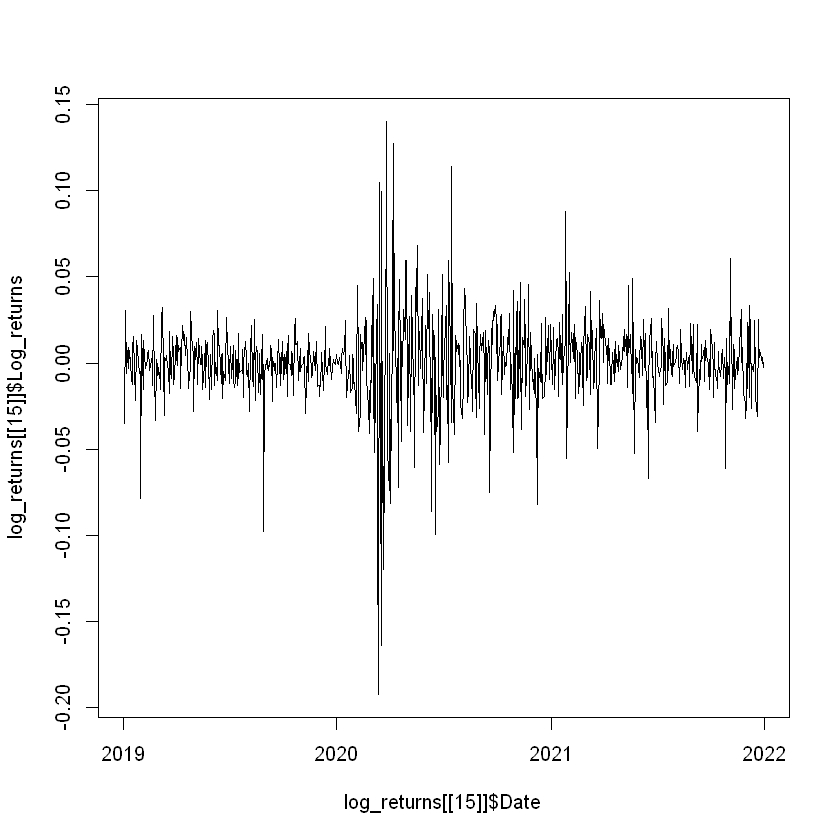

In [9]:
plot(x=log_returns[[15]]$Date, y=log_returns[[15]]$Log_returns, type="l")

In [10]:
#Just some notes

#plot ACF and PACF of logrets? or logrets^2?
#lagrange multiplier test for ARCH effect? (arch.test)?
#alpha - effetc of past excess return (ret. different from mean), beta - effect of variance (volatility) from the previous period

### 2) Estimating GARCH(1,1) models

In [13]:
library(rugarch)

Warning message:
"package 'rugarch' was built under R version 4.1.3"
Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma




In [42]:
#Estimating GARCH(1,1) models and saving fitted objects in list
garch_list <- vector("list", length(tickers_data))

for(i in 1:length(tickers_data)){
    garch_spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0)), variance.model = list(garchOrder = c(1, 1)))
    garch_fit <- ugarchfit(garch_spec, na.omit(log_returns[[i]]$Log_returns))

    garch_list[[i]] <- garch_fit
}

### 3) Extracting and plotting alphas and betas

In [58]:
coef_df <- data.frame(Firm = tickers, 
                    alphas = rep(NA, length(tickers_data)), 
                    betas = rep(NA, length(tickers_data)), 
                    ab_sum = rep(NA, length(tickers_data)))

In [63]:
for(i in 1:length(tickers_data)){
    coef_df$alphas[i] <- as.numeric(coef(garch_list[[i]])[3])
    coef_df$betas[i] <- as.numeric(coef(garch_list[[i]])[4])
    coef_df$ab_sum[i] <- as.numeric(coef(garch_list[[i]])[3]) + as.numeric(coef(garch_list[[i]])[4])
}

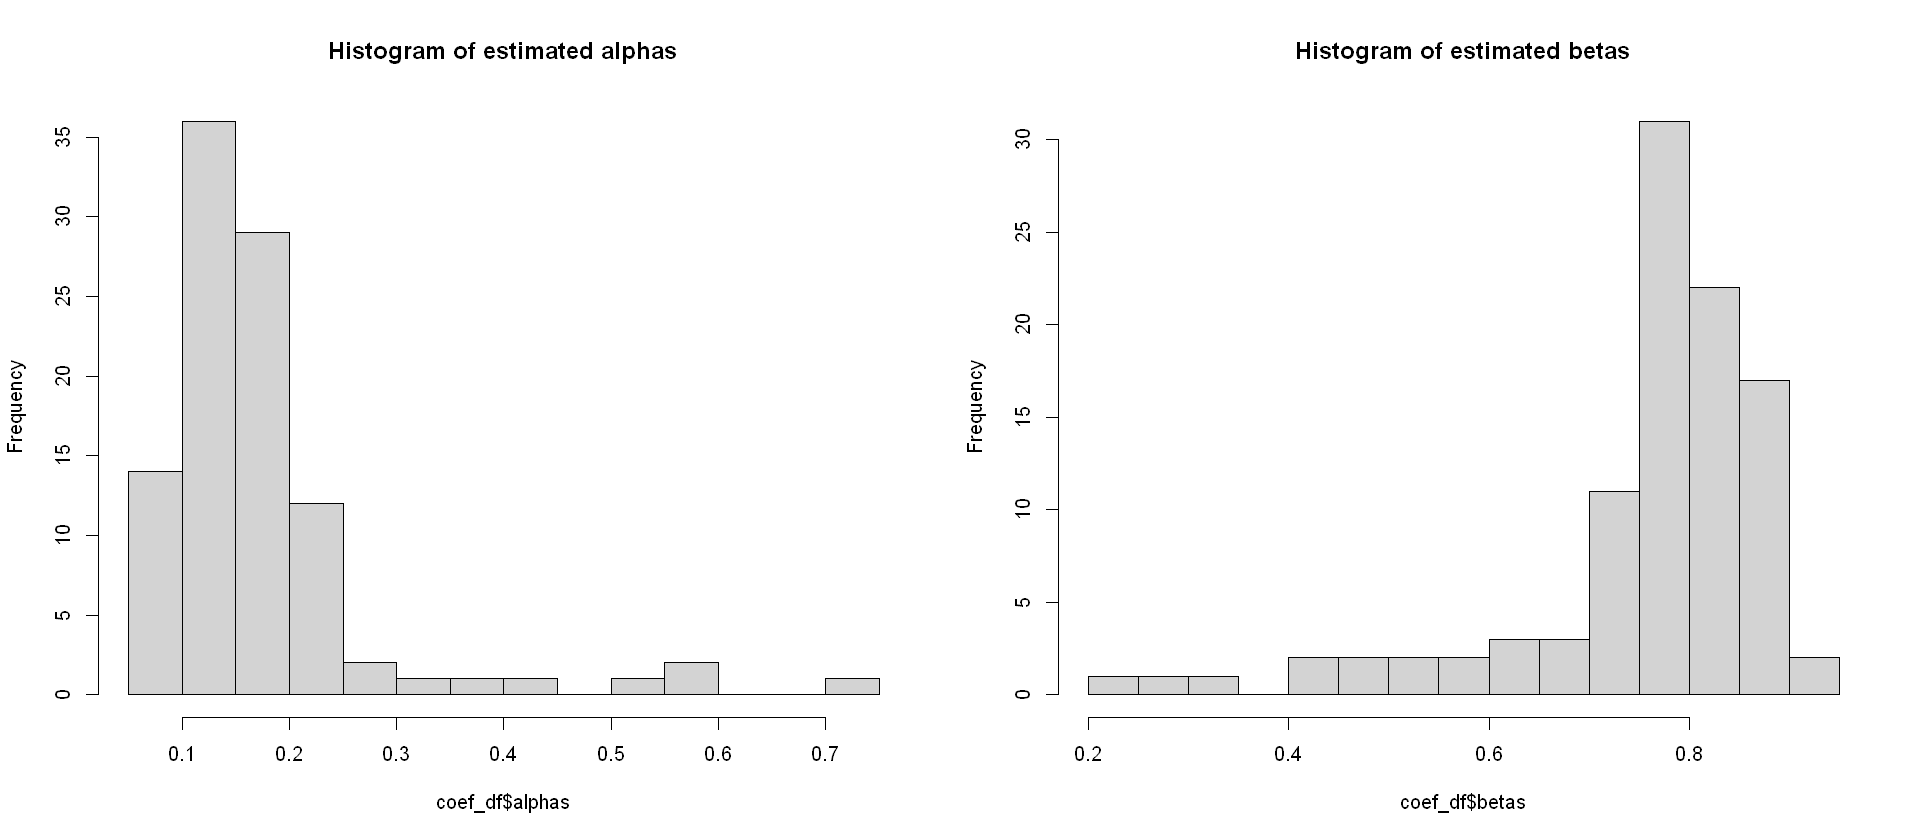

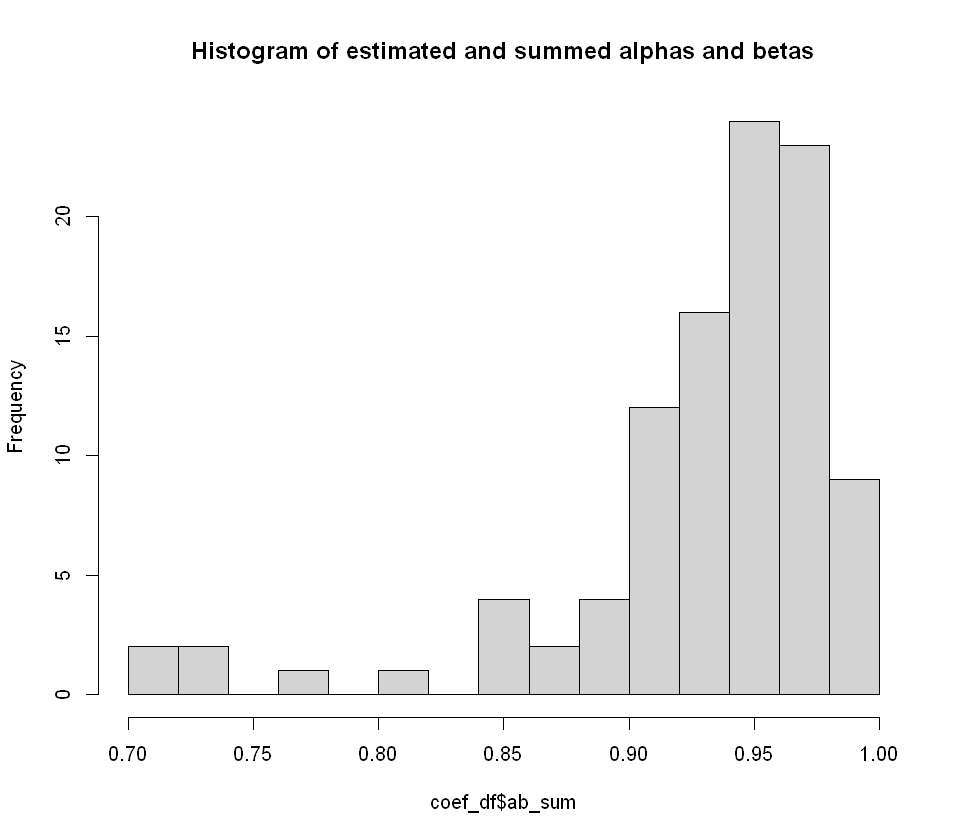

In [103]:
#ploting the crossection of coefficients
options(repr.plot.width = 16, repr.plot.height = 7)
par(mfrow = c(1, 2))
hist(coef_df$alphas, breaks = 10, main = "Histogram of estimated alphas")
hist(coef_df$betas, breaks = 10, main = "Histogram of estimated betas")
options(repr.plot.width = 8, repr.plot.height = 7)
par(mfrow = c(1, 1))
hist(coef_df$ab_sum, breaks = 11, main = "Histogram of estimated and summed alphas and betas")

### 4) Maximum estimated coefficients

In [117]:
#alpha
m_a <- max(coef_df$alphas)
m_a_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_a, coef_df$alphas)]]

#beta
m_b <- max(coef_df$betas)
m_b_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_b, coef_df$betas)]]

#sums
m_ab <- max(coef_df$ab_sum)
m_ab_name <- symbols2$Name[symbols2$Symbol == coef_df$Firm[match(m_ab, coef_df$ab_sum)]]

print(paste("Maximum estimated alpha:", m_a, "for firm", m_a_name))
print(paste("Maximum estimated beta:", m_b, "for firm", m_b_name))
print(paste("Maximum estimated sum:", m_ab, "for firm", m_ab_name))

[1] "Maximum estimated alpha: 0.704289393725199 for firm Hasbro Inc."
[1] "Maximum estimated beta: 0.915573209232825 for firm Newmont Mining Corp. (Hldg. Co.)"
[1] "Maximum estimated sum: 0.998999987822922 for firm Host Hotels & Resorts"
